# Deep Survival Machines Demo Code
Note: this is slightly modified demo code from the Auton Survival python package documentation: https://autonlab.org/auton-survival/

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from auton_survival.models.dsm import DeepSurvivalMachines, DeepRecurrentSurvivalMachines
from auton_survival import datasets
from auton_survival.preprocessing import Preprocessor

from sklearn.model_selection import ParameterGrid
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

In [28]:
import auton_survival
print(auton_survival.__file__)

C:\Users\jackj\school\fall2024\orie4999\auton_survival\__init__.py


### Data Preprocessing

In [2]:
outcomes, features = datasets.load_support()

In [3]:
cat_feats = ['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca']
num_feats = ['age', 'num.co', 'meanbp', 'wblc', 'hrt', 'resp', 
             'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph', 
             'glucose', 'bun', 'urine', 'adlp', 'adls']

features = Preprocessor().fit_transform(features, cat_feats=cat_feats, num_feats=num_feats)

In [4]:
horizons = [0.25, 0.5, 0.75]
times = np.quantile(outcomes.time[outcomes.event==1], horizons).tolist()

In [5]:
x, t, e = features.values, outcomes.time.values, outcomes.event.values

x = np.array(x, dtype = float)
t = np.array(t, dtype = float)
e = np.array(e, dtype = float)

n = len(x)

tr_size = int(n*0.70)
vl_size = int(n*0.10)
te_size = int(n*0.20)

x_train, x_test, x_val = x[:tr_size], x[-te_size:], x[tr_size:tr_size+vl_size]
t_train, t_test, t_val = t[:tr_size], t[-te_size:], t[tr_size:tr_size+vl_size]
e_train, e_test, e_val = e[:tr_size], e[-te_size:], e[tr_size:tr_size+vl_size]

### Model Training
Train models with varying k values, distributions, learning rates, and number of layers

In [6]:
param_grid = {'k' : [3, 4, 6],
              'distribution' : ['LogNormal', 'Weibull'],
              'learning_rate' : [ 1e-4, 1e-3],
              'layers' : [ [], [100], [100, 100] ]
             }
params = ParameterGrid(param_grid)

In [7]:
models = []
for param in params:
    model = DeepSurvivalMachines(
        k=param['k'],
        distribution=param['distribution'],
        layers=param['layers']
    )
    
    model.fit(x_train, t_train, e_train, iters=100, learning_rate=param['learning_rate'])
    nll = model.compute_nll(x_val, t_val, e_val)
    models.append({'nll': nll, 'model': model, 'params': param})

best_model_info = min(models, key=lambda x: x['nll'])
best_model = best_model_info['model']
best_params = best_model_info['params']
best_nll = best_model_info['nll']
model = best_model
print("Best Model NLL:", best_nll)
print("Best Model Parameters:", best_params)

 14%|███████████▎                                                                     | 14/100 [00:05<00:33,  2.60it/s]

Best Model NLL: 1.7793777869788043
Best Model Parameters: {'distribution': 'LogNormal', 'k': 3, 'layers': [100], 'learning_rate': 0.0001}


### Evaluation

In [8]:
out_risk = model.predict_risk(x_test, times)
out_survival = model.predict_survival(x_test, times)

In [9]:
cis = []
brs = []

et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))],
                 dtype = [('e', bool), ('t', float)])
et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))],
                 dtype = [('e', bool), ('t', float)])
et_val = np.array([(e_val[i], t_val[i]) for i in range(len(e_val))],
                 dtype = [('e', bool), ('t', float)])

for i, _ in enumerate(times):
    cis.append(concordance_index_ipcw(et_train, et_test, out_risk[:, i], times[i])[0])
brs.append(brier_score(et_train, et_test, out_survival, times)[1])
roc_auc = []
for i, _ in enumerate(times):
    roc_auc.append(cumulative_dynamic_auc(et_train, et_test, out_risk[:, i], times[i])[0])
for horizon in enumerate(horizons):
    print(f"For {horizon[1]} quantile,")
    print("TD Concordance Index:", cis[horizon[0]])
    print("Brier Score:", brs[0][horizon[0]])
    print("ROC AUC ", roc_auc[horizon[0]][0], "\n")

For 0.25 quantile,
TD Concordance Index: 0.7654588597145041
Brier Score: 0.1113722042876009
ROC AUC  0.7726522677974235 

For 0.5 quantile,
TD Concordance Index: 0.7028085372828209
Brier Score: 0.18272355422012257
ROC AUC  0.7233134711382971 

For 0.75 quantile,
TD Concordance Index: 0.6598328655895858
Brier Score: 0.2213274872450867
ROC AUC  0.7150287756709275 



# Recurrent Deep Survival Machines Demo Code
Note: this is slightly modified demo code from the Auton Survival python package documentation: https://autonlab.org/auton-survival/

### Data Preprocessing

In [14]:
x, t, e = datasets.load_dataset('PBC', sequential = True)
horizons = [0.25, 0.5, 0.75]
times = np.quantile([t_[-1] for t_, e_ in zip(t, e) if e_[-1] == 1], horizons).tolist()

n = len(x)

tr_size = int(n*0.70)
vl_size = int(n*0.10)
te_size = int(n*0.20)

x_train, x_test, x_val = np.array(x[:tr_size], dtype = object), np.array(x[-te_size:], dtype = object), np.array(x[tr_size:tr_size+vl_size], dtype = object)
t_train, t_test, t_val = np.array(t[:tr_size], dtype = object), np.array(t[-te_size:], dtype = object), np.array(t[tr_size:tr_size+vl_size], dtype = object)
e_train, e_test, e_val = np.array(e[:tr_size], dtype = object), np.array(e[-te_size:], dtype = object), np.array(e[tr_size:tr_size+vl_size], dtype = object)

In [28]:
t_train.shape

(218,)

### Model Training

In [15]:
param_grid = {'k' : [3, 4, 6],
              'distribution' : ['LogNormal', 'Weibull'],
              'learning_rate' : [1e-4, 1e-3],
              'hidden': [50, 100],
              'layers': [3, 2, 1],
              'typ': ['LSTM', 'GRU', 'RNN'],
             }
params = ParameterGrid(param_grid)

models = []
for param in params:
    model = DeepRecurrentSurvivalMachines(k = param['k'],
                                 distribution = param['distribution'],
                                 hidden = param['hidden'], 
                                 typ = param['typ'],
                                 layers = param['layers'])
    
    model.fit(x_train, t_train, e_train, iters = 1, learning_rate = param['learning_rate'])
    nll = model.compute_nll(x_val, t_val, e_val)
    models.append({'nll': nll, 'model': model, 'params': param})

best_model_info = min(models, key=lambda x: x['nll'])
best_model = best_model_info['model']
best_params = best_model_info['params']
best_nll = best_model_info['nll']
model = best_model
print("Best Model NLL:", best_nll)
print("Best Model Parameters:", best_params)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.49it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.53it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.82it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.49it/s]


Best Model NLL: 0.9937310272812337
Best Model Parameters: {'distribution': 'Weibull', 'hidden': 50, 'k': 4, 'layers': 1, 'learning_rate': 0.001, 'typ': 'RNN'}


### Evaluation

In [16]:
out_risk = model.predict_risk(x_test, times)
out_survival = model.predict_survival(x_test, times)

cis = []
brs = []

et_train = np.array([(e_train[i][j], t_train[i][j]) for i in range(len(e_train)) for j in range(len(e_train[i]))],
                 dtype = [('e', bool), ('t', float)])
et_test = np.array([(e_test[i][j], t_test[i][j]) for i in range(len(e_test)) for j in range(len(e_test[i]))],
                 dtype = [('e', bool), ('t', float)])
et_val = np.array([(e_val[i][j], t_val[i][j]) for i in range(len(e_val)) for j in range(len(e_val[i]))],
                 dtype = [('e', bool), ('t', float)])

for i, _ in enumerate(times):
    cis.append(concordance_index_ipcw(et_train, et_test, out_risk[:, i], times[i])[0])
brs.append(brier_score(et_train, et_test, out_survival, times)[1])
roc_auc = []
for i, _ in enumerate(times):
    roc_auc.append(cumulative_dynamic_auc(et_train, et_test, out_risk[:, i], times[i])[0])
for horizon in enumerate(horizons):
    print(f"For {horizon[1]} quantile,")
    print("TD Concordance Index:", cis[horizon[0]])
    print("Brier Score:", brs[0][horizon[0]])
    print("ROC AUC ", roc_auc[horizon[0]][0], "\n")

For 0.25 quantile,
TD Concordance Index: 0.9015748031496064
Brier Score: 0.004328819764850914
ROC AUC  0.9051383399209487 

For 0.5 quantile,
TD Concordance Index: 0.9471684503736253
Brier Score: 0.012148739865693588
ROC AUC  0.9555471011846373 

For 0.75 quantile,
TD Concordance Index: 0.8892376898017548
Brier Score: 0.0286592619508703
ROC AUC  0.8959676636108452 



# Next Steps:
I have now practiced implementing both DSMs and RDSMs in Python. I can now apply these models to other contexts. Next steps include finding a dataset to fit a model on, identify relevant evaluation metrics for the context, and tune hyperparameters (in a more efficient manner than grid search) to achieve desired results.

I still do not have a great understanding of the evaluation metrics being used:
* TD Concordance Index
* Brier Score
* ROC AUC

# Deep Dive Into PBC Dataset
For more information see: https://stat.ethz.ch/R-manual/R-devel/library/survival/html/pbc.html

##### Mayo Clinic Primary Biliary Cholangitis Data  
###### Description  
Primary biliary cholangitis is an autoimmune disease leading to destruction of the small bile ducts in the liver. Progression is slow but inexhortable, eventually leading to cirrhosis and liver decompensation. The condition has been recognised since at least 1851 and was named "primary biliary cirrhosis" in 1949. Because cirrhosis is a feature only of advanced disease, a change of its name to "primary biliary cholangitis" was proposed by patient advocacy groups in 2014.  

This data is from the Mayo Clinic trial in PBC conducted between 1974 and 1984. A total of 424 PBC patients, referred to Mayo Clinic during that ten-year interval, met eligibility criteria for the randomized placebo controlled trial of the drug D-penicillamine. The first 312 cases in the data set participated in the randomized trial and contain largely complete data. The additional 112 cases did not participate in the clinical trial, but consented to have basic measurements recorded and to be followed for survival. Six of those cases were lost to follow-up shortly after diagnosis, so the data here are on an additional 106 cases as well as the 312 randomized participants.  

A nearly identical data set found in appendix D of Fleming and Harrington; this version has fewer missing values.  

###### Breakdown
The dataset contains three different arrays: x, t, e.  

x: Feature vectors which contain covariates from each time step  
t: Time to event data which indicates how much time from each reading to the event (primary outcome or censoring)
e: Binary variable indicating whether or not the event for patient is the primary outcome (1) or censoring (0)

x, t, e all have the same length i.e. the number of readings  
e arrays have all the same values

###### Structure

In [2]:
x, t, e = datasets.load_dataset('PBC', sequential = True)
x = np.array(x, dtype = object)
t = np.array(t, dtype = object)
e = np.array(e, dtype = object)


In [3]:
def print_data(i, x, t, e):
    print('Data for patient i =', i)
    print('x: ', x[i][0], 'x', x[i].shape[0])
    print('t: ', t[i])
    print('e: ', e[i])
    
print_data(0, x, t, e)

Data for patient i = 0
x:  [ 0.99436038 -0.99436038  0.3725034  -0.3725034  -2.73741663  3.24173962
 -0.97913787  1.0425497  -1.43799282  1.54166667 -1.6047952   3.28449064
 -0.49195313 -0.22660837 -0.39802969 -0.67758009  1.00051427  2.0158767
 -0.46946083 -1.5706465   0.28561281  0.19548755 -0.45602232  0.81313216
  0.2480577 ] x 2
t:  [1.0951703  0.56948856]
e:  [1 1]


In [4]:
def test_arrays(arrays):
    for arr in arrays:
        if not np.all(arr == arr[0]):
            return True  # Found an array with non-identical values
        return False
test_arrays(e)

False

This shows that all entries in e have the same values.  

###### Dataset Statistics
First we will look at the distribution of the number of readings taken per patient

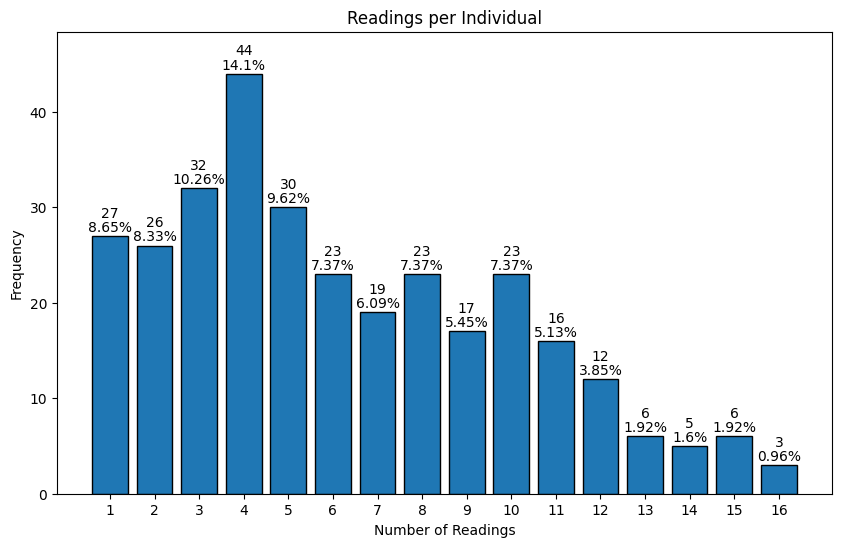

In [6]:
readings = []
n = len(x)
for entry in x:
    readings.append(entry.shape[0])

bins = np.arange(1, max(readings)+2)

plt.figure(figsize=(10, 6))
counts, _, _ = plt.hist(readings, bins=bins, edgecolor='black', align='left', rwidth=0.8)
plt.ylim(0, max(counts) * 1.1)

plt.xlabel("Number of Readings")
plt.ylabel("Frequency")
plt.title("Readings per Individual")

for i in range(1, max(readings)+1):
    plt.text(i, counts[i-1] + 0.5, str(round(100 * counts[i-1]/n, 2)) + '%', ha='center')
    plt.text(i, counts[i-1] + 2, str(int(counts[i-1])), ha='center')

plt.xticks(np.arange(1, max(readings)+1))
plt.show()

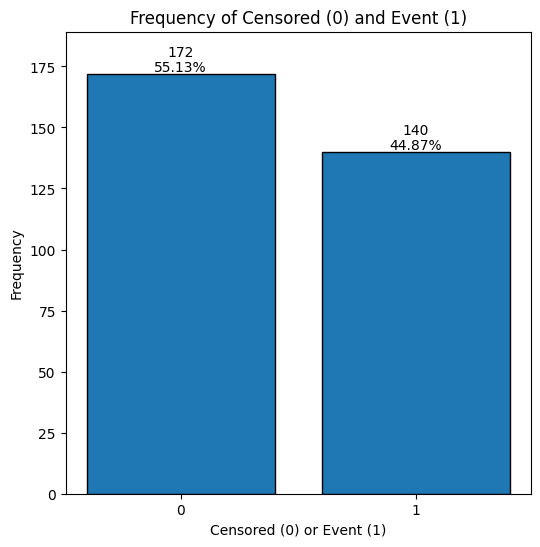

In [7]:
data = []
for entry in e:
    data.append(entry[0])
n = len(e)

bins = [0, 1, 2]  

plt.figure(figsize=(6, 6))
counts, _, _ = plt.hist(data, bins=bins, edgecolor='black', align='left', rwidth=0.8)
plt.ylim(0, max(counts) * 1.1)

plt.xlabel("Censored (0) or Event (1)")
plt.ylabel("Frequency")
plt.title("Frequency of Censored (0) and Event (1)")

plt.xticks([0, 1])

for i in [0, 1]:
    plt.text(i, counts[i] + 7, str(int(counts[i])), ha='center')
    plt.text(i, counts[i] + 1, str(round(100 * counts[i]/n, 2)) + '%', ha='center')

plt.show()

In [8]:
vals = [i for i in range(1, 17)]
time_data = {}
for val in vals:
    time_data[val] = []
    for entry in t:
        if len(entry) >= val:
            time_data[val].append(entry[val-1])
# for val in vals:
#     time_data[val]
    
stats = {
        'Avg': [],
        'Med': [],
        'Std': [],
        'Min': [],
        'Max': []
    }
    
for key, values in time_data.items():
    stats['Avg'].append(np.mean(values))
    stats['Med'].append(np.median(values))
    stats['Std'].append(np.std(values))
    stats['Min'].append(np.min(values))
    stats['Max'].append(np.max(values))

df = pd.DataFrame(stats, index=time_data.keys())
df.index.name = 'Readings'

df

,Avg,Med,Std,Min,Max
Readings,,,,,
1,6.411239,6.295860,3.557073,0.112255,14.305662
2,6.123616,5.900230,3.434504,0.043807,13.793670
3,5.788979,5.590844,3.474687,0.013690,13.218706
4,5.136807,4.859818,3.338387,0.002738,12.222101
5,4.906737,4.878984,3.018170,0.005476,11.206330
6,4.530551,4.238309,2.759107,0.002738,10.209725
7,3.902766,3.645548,2.546701,0.035593,9.226810
8,3.431756,3.137663,2.318410,0.021903,8.216515
9,3.088536,2.929581,2.045479,0.002738,7.239076


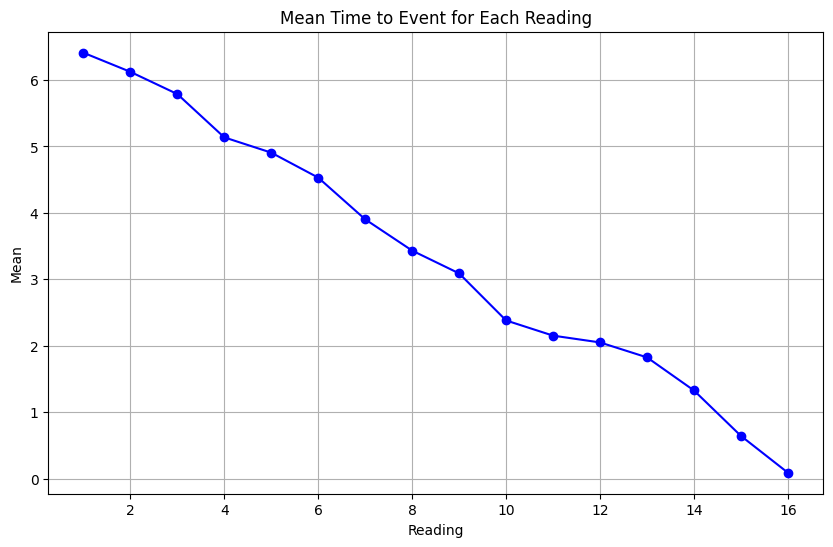

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Avg'], marker='o', linestyle='-', color='b')

# Labels and title
plt.xlabel("Reading")
plt.ylabel("Mean")
plt.title("Mean Time to Event for Each Reading")

plt.grid(True)
plt.show()

In [10]:
def trim_array(max_length, arr):
    result = []
    for a in arr:
        if len(a) > max_length:
            result.append(a[:max_length])
        else:
            result.append(a)
    return result

def mask_data(max_readings, x, t, e):
    x_new = trim_array(max_readings, x)
    t_new = trim_array(max_readings, t)
    e_new = trim_array(max_readings, e)
    return x_new, t_new, e_new

def train_model_with_masked_data(max_readings, x, t, e):
    if max_readings:
        x, t, e = mask_data(max_readings, x, t, e)
    return train_model(x, t, e)

def train_model(x, t, e):
    horizons = [0.25, 0.5, 0.75]
    times = np.quantile([t_[-1] for t_, e_ in zip(t, e) if e_[-1] == 1], horizons).tolist()

    n = len(x)

    tr_size = int(n*0.70)
    vl_size = int(n*0.10)
    te_size = int(n*0.20)

    x_train, x_test, x_val = np.array(x[:tr_size], dtype = object), np.array(x[-te_size:], dtype = object), np.array(x[tr_size:tr_size+vl_size], dtype = object)
    t_train, t_test, t_val = np.array(t[:tr_size], dtype = object), np.array(t[-te_size:], dtype = object), np.array(t[tr_size:tr_size+vl_size], dtype = object)
    e_train, e_test, e_val = np.array(e[:tr_size], dtype = object), np.array(e[-te_size:], dtype = object), np.array(e[tr_size:tr_size+vl_size], dtype = object)
    
    param_grid = {'k' : [3, 4, 6],
              'distribution' : ['Weibull'],
              'learning_rate' : [1e-4, 1e-3],
              'hidden': [50],
              'layers': [1],
              'typ': ['RNN'],
             }
    params = ParameterGrid(param_grid)

    models = []
    for param in params:
        model = DeepRecurrentSurvivalMachines(k = param['k'],
                                     distribution = param['distribution'],
                                     hidden = param['hidden'], 
                                     typ = param['typ'],
                                     layers = param['layers'])

        model.fit(x_train, t_train, e_train, iters = 1, learning_rate = param['learning_rate'])
        nll = model.compute_nll(x_val, t_val, e_val)
        models.append({'nll': nll, 'model': model, 'params': param})

    best_model_info = min(models, key=lambda x: x['nll'])
    best_model = best_model_info['model']
    best_params = best_model_info['params']
    best_nll = best_model_info['nll']
    model = best_model
    print("Best Model NLL:", best_nll)
    print("Best Model Parameters:", best_params)
    
    out_risk = model.predict_risk(x_test, times)
    out_survival = model.predict_survival(x_test, times)

    cis = []
    brs = []

    et_train = np.array([(e_train[i][j], t_train[i][j]) for i in range(len(e_train)) for j in range(len(e_train[i]))],
                     dtype = [('e', bool), ('t', float)])
    et_test = np.array([(e_test[i][j], t_test[i][j]) for i in range(len(e_test)) for j in range(len(e_test[i]))],
                     dtype = [('e', bool), ('t', float)])
    et_val = np.array([(e_val[i][j], t_val[i][j]) for i in range(len(e_val)) for j in range(len(e_val[i]))],
                     dtype = [('e', bool), ('t', float)])

    for i, _ in enumerate(times):
        cis.append(concordance_index_ipcw(et_train, et_test, out_risk[:, i], times[i])[0])
    brs.append(brier_score(et_train, et_test, out_survival, times)[1])
    roc_auc = []
    for i, _ in enumerate(times):
        roc_auc.append(cumulative_dynamic_auc(et_train, et_test, out_risk[:, i], times[i])[0])
    for horizon in enumerate(horizons):
        print(f"For {horizon[1]} quantile,")
        # print("TD Concordance Index:", cis[horizon[0]])
        # print("Brier Score:", brs[0][horizon[0]])
        print("ROC AUC ", roc_auc[horizon[0]][0], "\n")
    
    return model

In [11]:
model = train_model_with_masked_data(None, x, t, e)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


Best Model NLL: 0.9937310272812337
Best Model Parameters: {'distribution': 'Weibull', 'hidden': 50, 'k': 4, 'layers': 1, 'learning_rate': 0.001, 'typ': 'RNN'}
For 0.25 quantile,
ROC AUC  0.9051383399209487 

For 0.5 quantile,
ROC AUC  0.9555471011846373 

For 0.75 quantile,
ROC AUC  0.8959676636108452 



**Previously for unmasked data:**

For 0.25 quantile,  
ROC AUC  0.9051383399209487 

For 0.5 quantile,  
ROC AUC  0.9555471011846373 

For 0.75 quantile,  
ROC AUC  0.8959676636108452 

1. Understanding the output of the DSM better — what are those 3 values (the 0.25, 0.5, 0.75) — are they predicting the amount of time the patient survives past the last viewed piece of panel data? i.e. a 0.25 value of t says there is a 25% chance the patient dies within t time units of the last observation? Or does it say there is a 25% chance the patient dies within t time units of the first observation? Or is the interpretation something different?

2. Once we understand the output better, we want think of which ways we want to express it so we can use it to differentiate between two groups — we might want to use the 0.5 value + a confidence interval, or a variance. Or we might also want to construct a full probability distribution based on this output. If we construct a full probability distribution, what approximate functional form does it take? (It will be truncated at the time of the last observation, since we know the patient survives until the last observation, so my first guess is that it might be exponential or gamma distributed). It would be good to see which of these are feasible & what exactly the output would look like.

3. We talked about attempting to construct some sort of synthetic data generator based on the data in this dataset. The first step in doing this is thinking about how we would describe what is going on in this dataset. If we just had one static observation per patient, we could think about fitting a prediction model like the DSM to our dataset which we would think of as the “ground truth” outcome process, and then generating data where we use some sort of random generator for covariates, use the covariates to make a prediction, and then add noise. The big challenge here is capturing the covariates, and thinking about how we would generate them especially with these changing variables in the panel dataset change over time. I think that the task for this week would be looking into whether there are good ways to do this sort of synthetic data generation.

In [12]:
model.torch_model

DeepRecurrentSurvivalMachinesTorch(
  (act): SELU()
  (shape): ParameterDict(  (1): Parameter containing: [torch.DoubleTensor of size 4])
  (scale): ParameterDict(  (1): Parameter containing: [torch.DoubleTensor of size 4])
  (gate): ModuleDict(
    (1): Sequential(
      (0): Linear(in_features=50, out_features=4, bias=False)
    )
  )
  (scaleg): ModuleDict(
    (1): Sequential(
      (0): Linear(in_features=50, out_features=4, bias=True)
    )
  )
  (shapeg): ModuleDict(
    (1): Sequential(
      (0): Linear(in_features=50, out_features=4, bias=True)
    )
  )
  (embedding): RNN(25, 50, bias=False, batch_first=True)
)

In [27]:
horizons = [0.25, 0.5, 0.75]
times = np.quantile([t_[-1] for t_, e_ in zip(t, e) if e_[-1] == 1], horizons).tolist()
print(np.exp([t_[-1] for t_, e_ in zip(t, e) if e_[-1] == 1]))
n = len(x)

tr_size = int(n*0.70)
vl_size = int(n*0.10)
te_size = int(n*0.20)

x_train, x_test, x_val = np.array(x[:tr_size], dtype = object), np.array(x[-te_size:], dtype = object), np.array(x[tr_size:tr_size+vl_size], dtype = object)
t_train, t_test, t_val = np.array(t[:tr_size], dtype = object), np.array(t[-te_size:], dtype = object), np.array(t[tr_size:tr_size+vl_size], dtype = object)
e_train, e_test, e_val = np.array(e[:tr_size], dtype = object), np.array(e[-te_size:], dtype = object), np.array(e[tr_size:tr_size+vl_size], dtype = object)

[1.76736291e+00 2.08861679e+00 1.31854717e+00 1.14670921e+00
 1.97191585e+00 1.39658077e+00 1.14985312e+00 1.20463781e+00
 1.40424921e+00 1.03623405e+00 1.13732898e+00 1.30061974e+00
 1.43534638e+00 1.03340080e+00 1.48328809e+00 2.35601294e+00
 1.25170912e+00 1.13111815e+00 1.02775751e+00 1.23469044e+00
 1.61026551e+00 7.60497759e+00 1.06208543e+00 1.97732221e+00
 1.57537868e+00 3.17537453e+02 1.24146997e+00 1.10056909e+00
 1.14670921e+00 1.72434492e+00 1.03907507e+00 1.25170912e+00
 1.65043751e+00 1.10661217e+00 2.42804873e+00 1.01656323e+00
 1.29706361e+00 2.33035136e+00 1.12802547e+00 1.02494744e+00
 1.00549087e+00 1.41971266e+00 1.04764495e+00 3.66114816e+00
 1.23131457e+00 1.02775751e+00 1.00549087e+00 1.38895420e+00
 1.00274168e+00 1.02214505e+00 1.36258770e+00 1.21457319e+00
 1.45912035e+00 8.23343107e+00 1.52446048e+00 1.03057529e+00
 5.97668169e+00 1.42750811e+00 9.33861422e+01 1.04478050e+00
 5.02988496e+02 1.21125232e+00 1.32216220e+00 1.30776127e+00
 2.90099307e+00 2.731412

In [31]:
def plot_survival_and_pdf(model, patient_data, patient_times, time_points, patient_num=None, risk=1):
    if not model.fitted:
        raise Exception("Model has not been fitted. Please train the model before using this function.")

    # Predict survival probabilities and PDF
    survival_probabilities = model.predict_survival(patient_data, time_points)
    pdf_values = model.predict_pdf(patient_data, time_points)
    mean_numerical = calculate_mean_time(pdf_values, time_points)
    mean_theoretical = model.predict_mean(patient_data)
    
    print('-'*50)
    print(f'Showing survival function and PDF for patient {patient_num}' if not patient_num is None else 'Showing survival function and PDF for patient')
    print(f'Mean time to survival (numerical): {mean_numerical}, (theoretical) {mean_theoretical}')
    print(f'True times {(patient_times)}')
    print('-'*50)
    
    # Create plots
    plt.figure(figsize=(10, 6))
    plt.plot(time_points, survival_probabilities[0], label="Survival Function", color="green")
    plt.xlabel("Time")
    plt.ylabel("Survival Probability")
    plt.title(f"Survival Function for Patient {patient_num}" if not patient_num is None else "Survival Function for Patient")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(time_points, pdf_values[0], label="Probability Density Function (PDF)", color="blue")
    plt.xlabel("Time")
    plt.ylabel("Probability Density")
    plt.title(f"Probability Density Function for Patient {patient_num}" if not patient_num is None else "Probability Density Function for Patient")
    plt.legend()
    plt.grid(True)
    plt.show()
    
def calculate_mean_time(pdf, times):
    if not isinstance(times, np.ndarray):
        times = np.array(times)
    
    times = times[1:]
    pdf = pdf[0, 1:]
    delta_t = np.diff(times)

    # Calculate the mean time using the trapezoidal rule
    mean_time = np.sum((times[:-1] + times[1:]) / 2 * pdf[:-1] * delta_t)

    return mean_time

In [32]:
t_test[1]

array([6.6778009 , 6.11652612, 5.74143029])

--------------------------------------------------
Showing survival function and PDF for patient 0
Mean time to survival (numerical): 10.882871613480573, (theoretical) [14.51753936]
True times [array([6.3163947])]
--------------------------------------------------


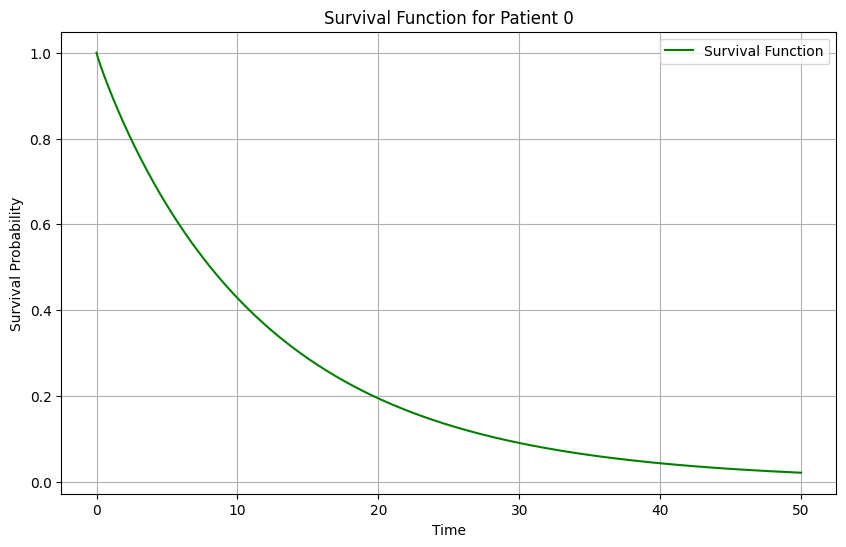

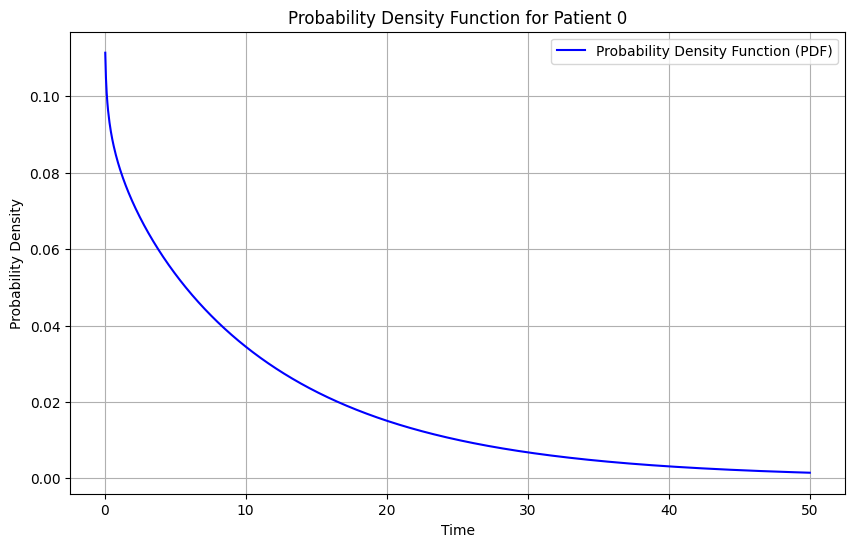

--------------------------------------------------
Showing survival function and PDF for patient 1
Mean time to survival (numerical): 10.351840023182618, (theoretical) [34.94947979 20.8141688  32.05971691]
True times [array([6.6778009 , 6.11652612, 5.74143029])]
--------------------------------------------------


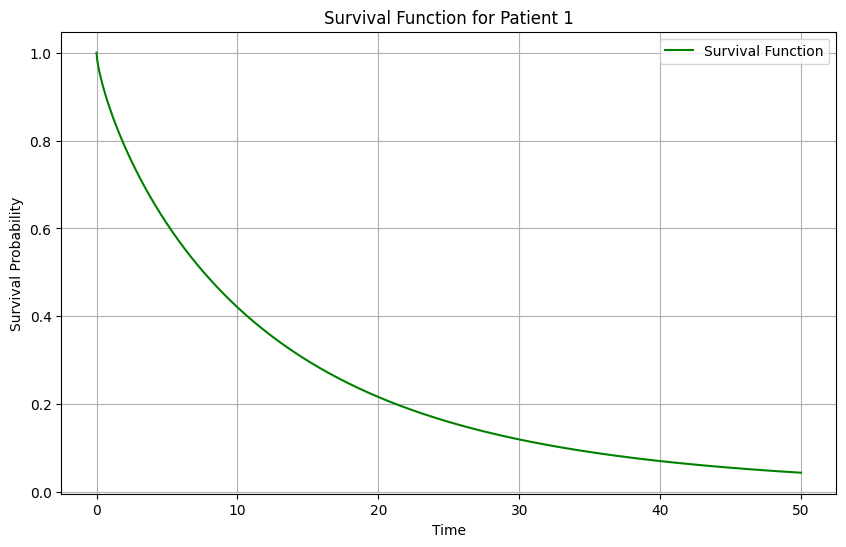

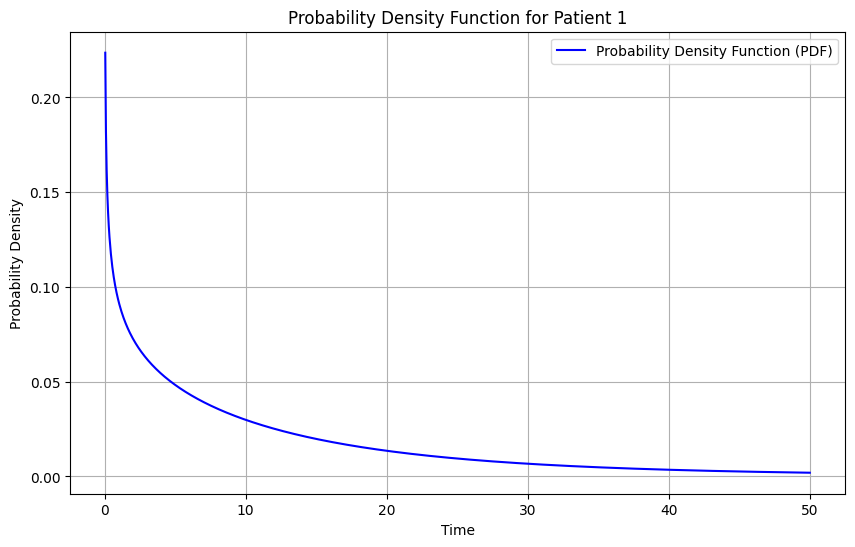

--------------------------------------------------
Showing survival function and PDF for patient 2
Mean time to survival (numerical): 8.557127854038649, (theoretical) [200.27348411  50.43024439 314.43665677 348.25191459 325.74520154
 428.92265713 702.98619009 672.32516836]
True times [array([6.66411127, 6.15759501, 5.58810645, 4.64625999, 3.51549666,
       2.55722265, 1.56609353, 0.45175775])]
--------------------------------------------------


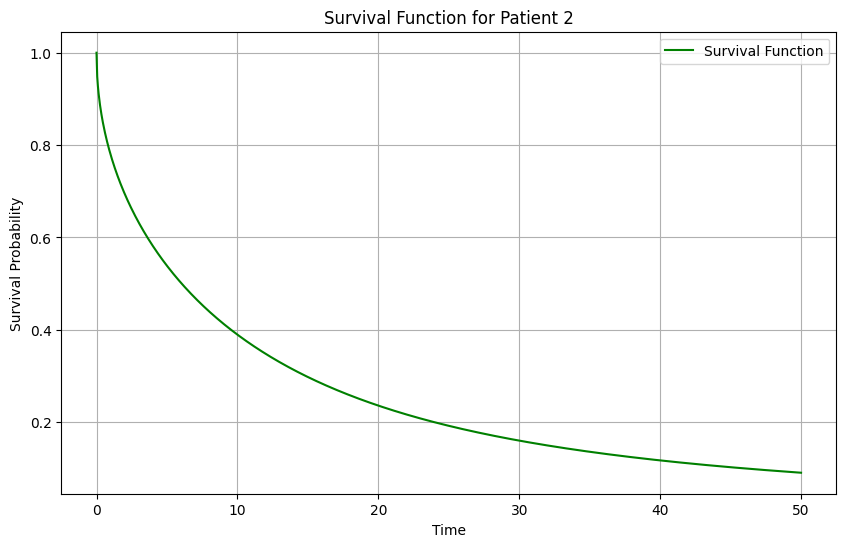

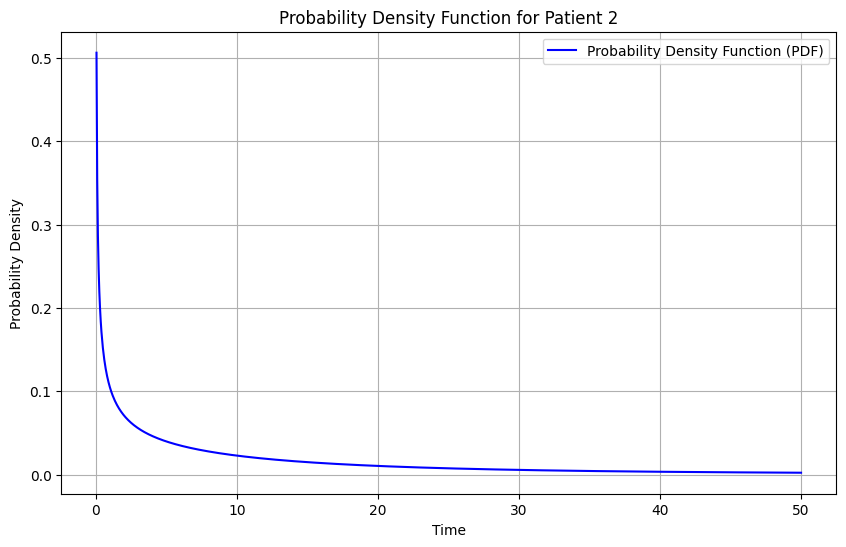

--------------------------------------------------
Showing survival function and PDF for patient 3
Mean time to survival (numerical): 10.00590316781659, (theoretical) [49.04846808 30.54743248 51.11552759 97.41852239]
True times [array([2.01785128, 1.51954879, 0.93363268, 0.22177199])]
--------------------------------------------------


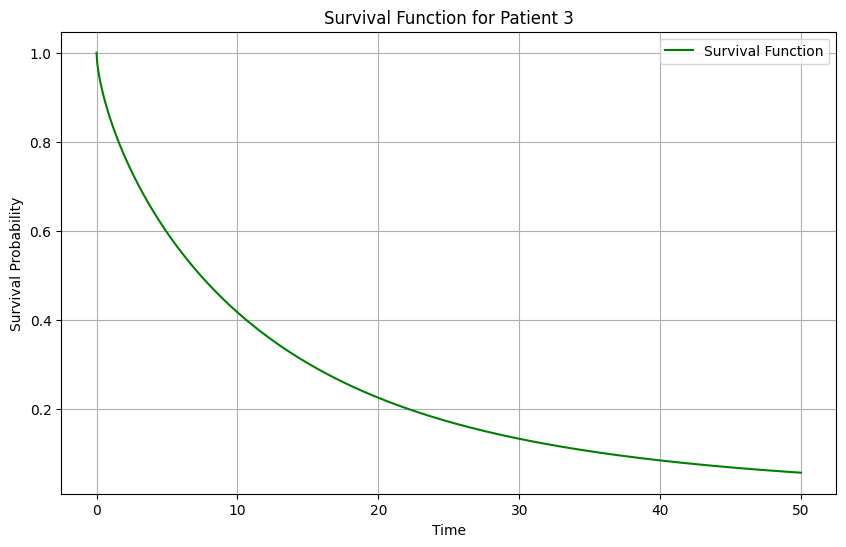

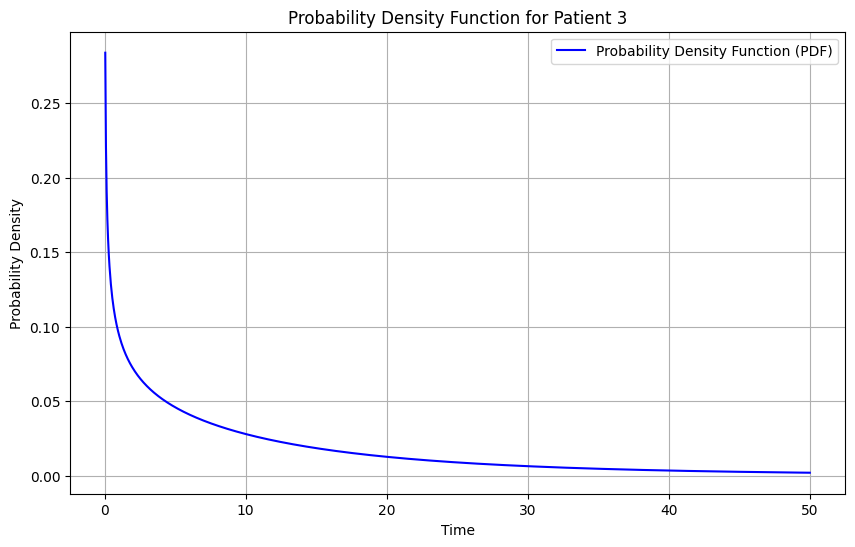

--------------------------------------------------
Showing survival function and PDF for patient 4
Mean time to survival (numerical): 10.287954672126062, (theoretical) [38.77968279 29.39420593 44.2701585  56.49022201 49.80147195 31.79251479]
True times [array([6.58471142, 6.08914686, 5.56620304, 4.57507392, 3.0199321 ,
       1.58252108])]
--------------------------------------------------


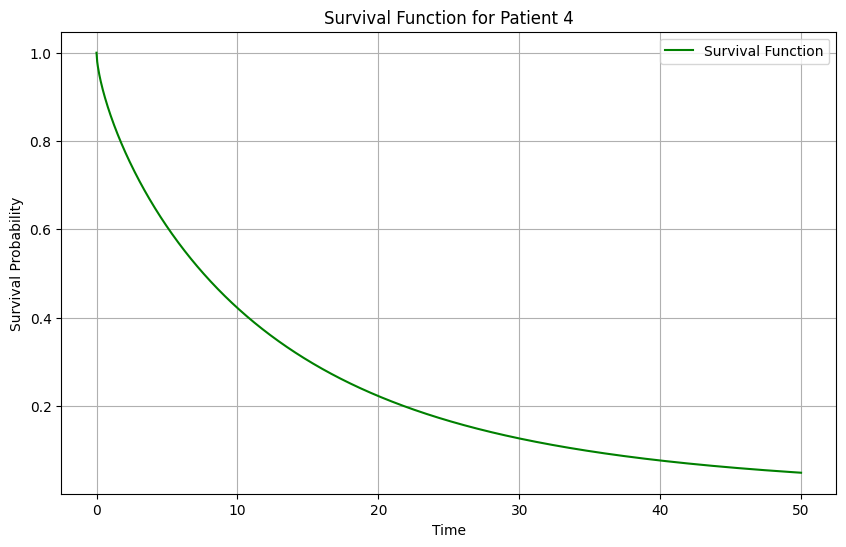

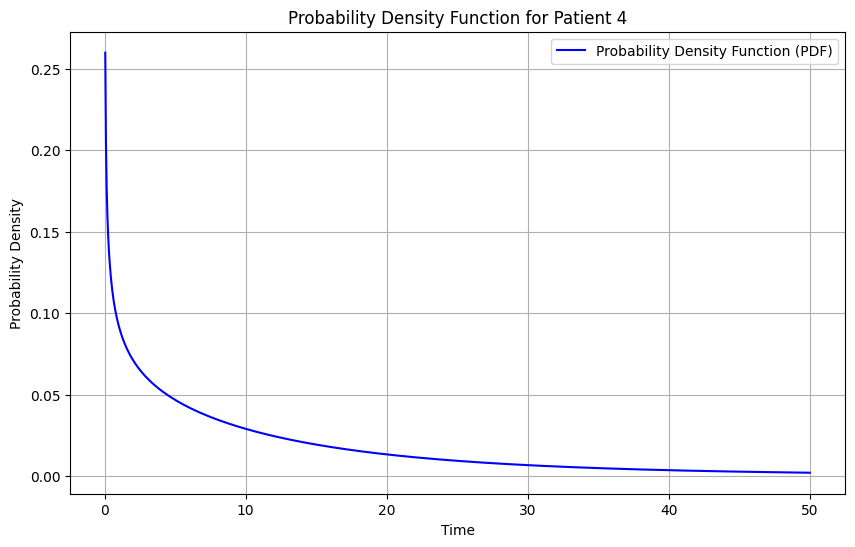

In [33]:
time_points = np.linspace(0, 50, 1000).tolist()
for i in range(5):
    patient_num = i
    patient_data = x_test[patient_num]
    patient_times = t_test[patient_num:patient_num+1].tolist()
    plot_survival_and_pdf(model, patient_data[np.newaxis, :, :], patient_times, time_points, patient_num=patient_num)

In [131]:
ts_uncensored = [t_[0] for t_, e_ in zip(t, e) if e_[0] == 1]
ts_censored = [t_[0] for t_, e_ in zip(t, e) if e_[0] == 0]
ts = [t_[0] for t_ in t]
avg_time = sum(ts)/len(ts)
avg_time_uncensored = sum(ts_uncensored)/len(ts_uncensored)
avg_time_censored = sum(ts_censored)/len(ts_censored)
print(f'Average Time: {avg_time:.2f}, Average Time Uncensored: {avg_time_uncensored:.2f}, Average Time Censored: {avg_time_censored:.2f}')

Average Time: 6.41, Average Time Uncensored: 4.43, Average Time Censored: 8.02


Look into tail biases and how to simulate a this data

# Time in the PBC Dataset
The following code indicates that time in the DSM survival function prediction is measured from the time since the patient's last visit

In [43]:
# Note the following code was pulled from the DSM package demo on the documentation website
horizons = [0.25, 0.5, 0.75]
times = np.quantile([t_[-1] for t_, e_ in zip(t, e) if e_[-1] == 1], horizons).tolist() # [-1] indicates time from last visit
np.exp(times)

array([1.10585498, 1.31314315, 2.02942765])

The following code indicates that the time used as "truth labels" in the model training is measured from the time of visit to time of event as the times decrease from visit to visit.

In [37]:
t_test[1]

array([6.6778009 , 6.11652612, 5.74143029])

In [41]:
x.shape

(312,)

In [42]:
np.exp(t_test[1])

array([794.5698492 , 453.28729049, 311.50964238])